# InceptionV3 Transfer Learning with Flowers Dataset
This notebook demonstrates how we can perform transfer learning using InceptionV3 in Keras with a multi-class Flowers RGB dataset.

In [1]:
!nvidia-smi

Thu Jan  1 06:24:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install split-folders -q

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


import splitfolders

### Download and unzip dataset

In [4]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!mkdir -p ./flowers_dataset
!tar -xvzf flower_photos.tgz -C ./flowers_dataset

--2026-01-01 06:24:35--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   324MB/s    in 0.7s    

2026-01-01 06:24:36 (324 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flowe

### Split folders

In [5]:
splitfolders.ratio("flowers_dataset/flower_photos", output="flowers_split", seed=42, ratio=(.7, .2, .1))

Copying files: 3670 files [00:01, 2544.78 files/s]


In [6]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30, zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'flowers_split/train', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
    'flowers_split/val', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    'flowers_split/test', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 2567 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 372 images belonging to 5 classes.


## Transfer Learning

### Load InceptionV3 and add custom layers

In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### Model training

In [8]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6086 - loss: 1.0690 - val_accuracy: 0.8167 - val_loss: 0.5220
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8534 - loss: 0.4602 - val_accuracy: 0.8605 - val_loss: 0.4187
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8983 - loss: 0.3257 - val_accuracy: 0.8577 - val_loss: 0.3871
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8886 - loss: 0.3291 - val_accuracy: 0.8714 - val_loss: 0.3570
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9204 - loss: 0.2562 - val_accuracy: 0.8851 - val_loss: 0.3301
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9123 - loss: 0.2575 - val_accuracy: 0.8755 - val_loss: 0.3273
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9300 - loss: 0.2187 - val_accuracy: 0.8837 - val_loss: 0.3301
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9297 - loss: 0.2193 - val_accuracy: 0.8933 - val_loss

### Performance Visuals

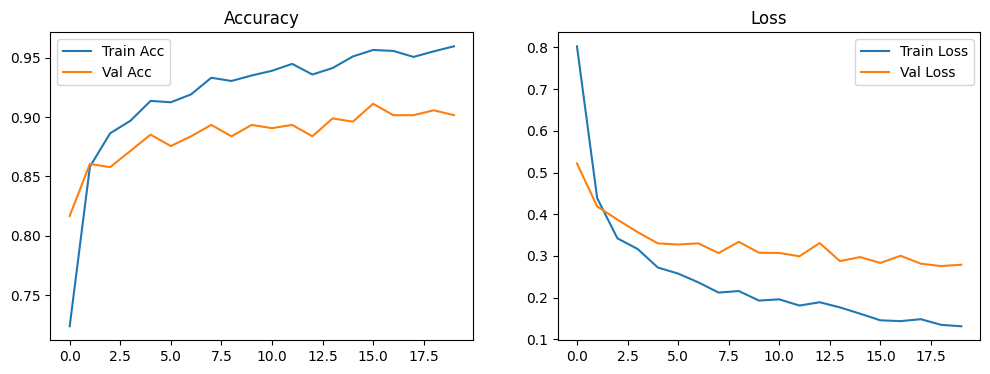

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

### Accuracy

In [10]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9188 - loss: 0.2270
Test Accuracy: 0.8898


### Prediction

In [11]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)
    class_index = np.argmax(preds)
    class_label = list(train_generator.class_indices.keys())[class_index]
    print(f"Prediction: {class_label} ({preds[0][class_index]*100:.2f}%)")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Try 1:

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Prediction: roses (99.97%)


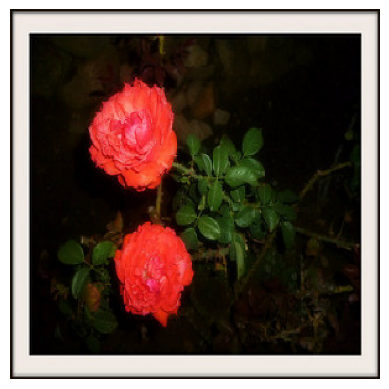

In [12]:
predict_image("/content/flowers_split/test/roses/15104537437_f6730b38c3_n.jpg")

### Try 2:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: sunflowers (98.85%)


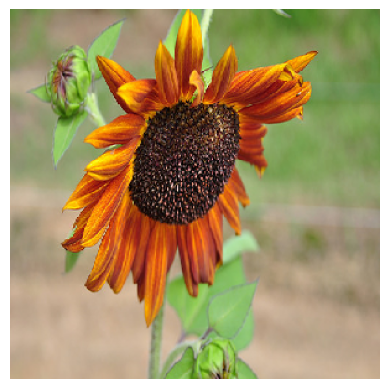

In [13]:
predict_image("/content/flowers_split/test/sunflowers/13117907313_86c99c6441.jpg")

### Try 3:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction: tulips (99.83%)


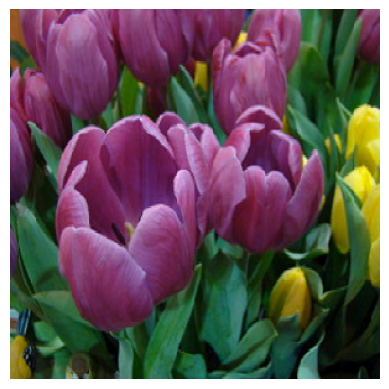

In [14]:
predict_image("/content/flowers_split/test/tulips/12916441224_2ed63596f8_n.jpg")